In [2]:
# describe analysis
df = pd.read_csv("bili_labeled_with_pred.csv")

# Step 1: Convert string labels to numeric sentiment values
df['pred_label_num'] = df['pred_label'].map({'LABEL_1': 1, 'LABEL_0': -1})

# Step 2: Compute the weighted sentiment score for each comment
df['result'] = df['pred_label_num'] * df['pred_score'] * df['weight']

# Display descriptive statistics for all columns, including 'result'
print(df.describe())

         like_count       weight   pred_score  pred_label_num       result
count   1073.000000  1073.000000  1073.000000     1073.000000  1073.000000
mean     485.765144     2.074490     0.771791        0.379310     0.721513
std     3845.354580     2.220086     0.126745        0.925701     2.309034
min        0.000000     0.000000     0.501042       -1.000000    -7.828197
25%        1.000000     0.693147     0.670768       -1.000000     0.000000
50%        3.000000     1.386294     0.794770        1.000000     0.515768
75%       18.000000     2.944439     0.889395        1.000000     1.634099
max    70541.000000    11.163964     0.949849        1.000000    10.091942


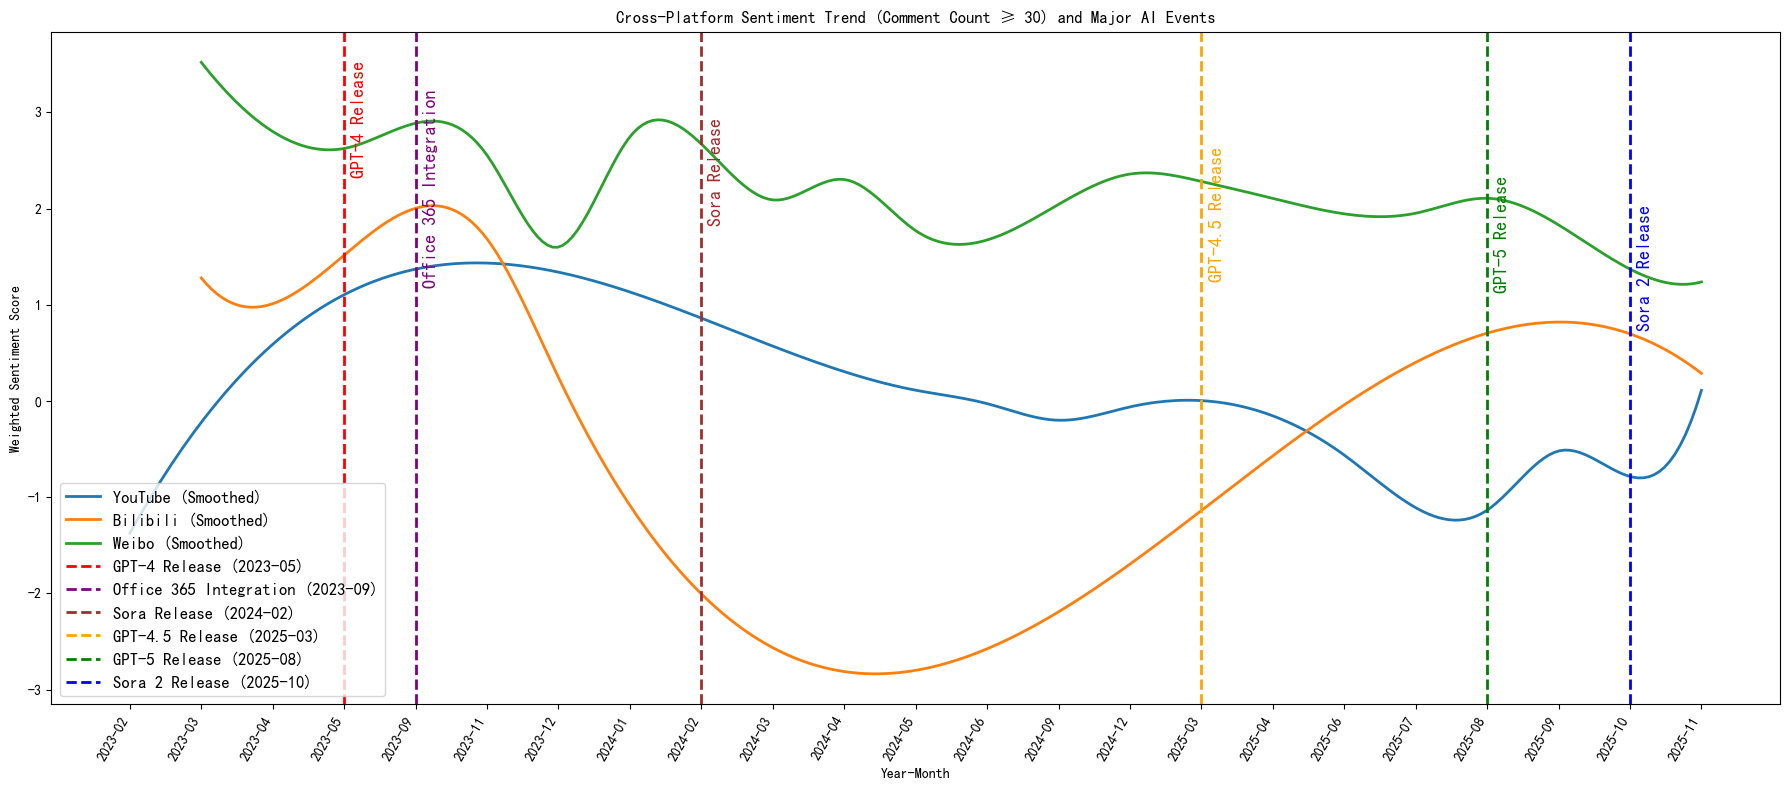

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline

plt.rcParams['font.sans-serif'] = ['SimHei']   # For non-Latin characters if needed
plt.rcParams['axes.unicode_minus'] = False

count_threshold = 30     # Minimum comment count threshold per month

platforms_info = {
    'YouTube': {
        'filename': 'youtube_labeled_with_pred_en.csv',
        'label_col': 'pred_label_en',
        'label_map': {'POSITIVE': 1, 'NEGATIVE': -1},
        'score_col': 'pred_score_en'
    },
    'Bilibili': {
        'filename': 'bili_labeled_with_pred.csv',
        'label_col': 'pred_label',
        'label_map': {'LABEL_1': 1, 'LABEL_0': -1},
        'score_col': 'pred_score'
    },
    'Weibo': {
        'filename': 'weibo_labeled_with_pred.csv',
        'label_col': 'pred_label',
        'label_map': {'LABEL_1': 1, 'LABEL_0': -1},
        'score_col': 'pred_score'
    }
}

# Key AI event markers (month: event name)
event_dict = {
    '2023-05': 'GPT-4 Release',
    '2023-09': 'Office 365 Integration',
    '2024-02': 'Sora Release',
    '2025-03': 'GPT-4.5 Release',
    '2025-08': 'GPT-5 Release',
    '2025-10': 'Sora 2 Release'
}

plt.figure(figsize=(18, 8))

all_valid_months = set()
platform_data = {}

for platform, info in platforms_info.items():
    df = pd.read_csv(info['filename'])
    df = df[df['year_month'] >= '2023-02'].copy()
    df['pred_label_num'] = df[info['label_col']].map(info['label_map'])
    df['weight'] = np.log(df['like_count'] + 1)
    df['result'] = df['pred_label_num'] * pd.to_numeric(df[info['score_col']], errors='coerce').fillna(0) * df['weight']
    monthly_count = df.groupby('year_month').size().reset_index(name='count')
    monthly_trend = df.groupby('year_month')['result'].mean().reset_index()
    merged = pd.merge(monthly_trend, monthly_count, on='year_month')
    valid = merged[merged['count'] >= count_threshold]
    months = valid['year_month'].tolist()
    y = pd.to_numeric(valid['result'], errors='coerce').fillna(0).values
    all_valid_months.update(months)
    platform_data[platform] = {'months': months, 'y': y}

# Add all event months to ensure all event markers are shown on the timeline
all_months = set(all_valid_months)
all_months.update(event_dict.keys())
all_months = sorted(list(all_months))
month_idx = {m: i for i, m in enumerate(all_months)}

for platform, data in platform_data.items():
    # Align each platform's data to all available months, fill missing with NaN
    y_aligned = np.full(len(all_months), np.nan)
    for m, v in zip(data['months'], data['y']):
        y_aligned[month_idx[m]] = v

    x_numeric = np.arange(len(all_months))
    # Use cubic spline for at least four valid (non-NaN) data points; otherwise, plot raw points
    if np.count_nonzero(~np.isnan(y_aligned)) >= 4:
        nonan_mask = ~np.isnan(y_aligned)
        x_for_interp = x_numeric[nonan_mask]
        y_for_interp = y_aligned[nonan_mask]
        xnew = np.linspace(x_for_interp.min(), x_for_interp.max(), 300)
        spline = make_interp_spline(x_for_interp, y_for_interp, k=3)
        y_smooth = spline(xnew)
        plt.plot(xnew, y_smooth, label=f"{platform} (Smoothed)", linewidth=2)
        # If you want to show raw data points as faded dots, uncomment next line:
        # plt.plot(x_for_interp, y_for_interp, 'o', alpha=0.3)
    else:
        plt.plot(x_numeric, y_aligned, marker='o', label=f"{platform} (Original)", linewidth=2)

# Draw vertical lines and annotated labels for each key event
color_list = ['red', 'purple', 'brown', 'orange', 'green', 'blue']
ylim_max = plt.ylim()[1]
for i, (event_month, event_name) in enumerate(event_dict.items()):
    if event_month in month_idx:
        idx = month_idx[event_month]
        plt.axvline(idx, color=color_list[i % len(color_list)], linestyle='--', linewidth=2,
                    label=f"{event_name} ({event_month})")
        plt.text(idx + 0.1, ylim_max - 0.3*(i+1), event_name,
                 color=color_list[i % len(color_list)], rotation=90, va='top', fontsize=13)

plt.xticks(ticks=np.arange(len(all_months)), labels=all_months, rotation=60, ha='right')
plt.legend(loc='best', fontsize=12)
plt.xlabel('Year-Month')
plt.ylabel('Weighted Sentiment Score')
plt.title(f'Cross-Platform Sentiment Trend (Comment Count ≥ {count_threshold}) and Major AI Events')
plt.tight_layout()
plt.show()

In [5]:
from scipy.stats import ttest_ind

result_table = {}

for event_month_str, event_name in event_dict.items():
    result_table[event_name] = {}
    event_month = pd.Period(event_month_str, freq='M')
    for platform, info in platforms_info.items():
        df = pd.read_csv(info['filename'])
        df['pred_label_num'] = df[info['label_col']].map(info['label_map'])
        df['weight'] = np.log(df['like_count'] + 1)
        df['result'] = df['pred_label_num'] * pd.to_numeric(df[info['score_col']], errors='coerce').fillna(0) * df['weight']
        df = df[['year_month', 'result']].copy()
        df['year_month'] = pd.PeriodIndex(df['year_month'], freq='M')

        # Select 12 months before and 12 months after each event for analysis
        before_mask = (df['year_month'] >= event_month - 11) & (df['year_month'] < event_month)
        after_mask = (df['year_month'] > event_month) & (df['year_month'] <= event_month + 11)
        result_before = df.loc[before_mask, 'result'].dropna().values
        result_after = df.loc[after_mask, 'result'].dropna().values

        mean_before = np.nan if len(result_before)==0 else np.mean(result_before)
        mean_after = np.nan if len(result_after)==0 else np.mean(result_after)

        # Two-sample t-test between pre-event and post-event periods
        if len(result_before) >= 2 and len(result_after) >= 2:
            t_stat, p_value = ttest_ind(result_before, result_after, equal_var=False)
        else:
            t_stat, p_value = np.nan, np.nan

        # Format cell output for cross-platform event-effect table
        cell_str = (
            f"Mean(before): {round(mean_before,3)}\n"
            f"Mean(after): {round(mean_after,3)}\n"
            f"t: {'' if np.isnan(t_stat) else round(t_stat,3)}\n"
            f"p: {'' if np.isnan(p_value) else round(p_value,3)}"
        )
        result_table[event_name][platform] = cell_str

# Create wide-format table (events as rows, platforms as columns)
table_df = pd.DataFrame(result_table).T
table_df.index.name = 'Event'
table_df.columns.name = 'Platform'

print(table_df)

# Save wide-format event-effect results to Excel (multi-line cell output)
table_df.to_excel('event_effect_results_all_platforms.xlsx')

Platform                                                          YouTube  \
Event                                                                       
GPT-4 Release           Mean(before): -0.648\nMean(after): 0.561\nt: -...   
Office 365 Integration  Mean(before): -0.653\nMean(after): 0.113\nt: -...   
Sora Release            Mean(before): -0.15\nMean(after): 0.01\nt: -0....   
GPT-4.5 Release         Mean(before): 0.013\nMean(after): -0.851\nt: 5...   
GPT-5 Release           Mean(before): -0.336\nMean(after): -0.549\nt: ...   
Sora 2 Release          Mean(before): -0.747\nMean(after): 0.11\nt: -2...   

Platform                                                         Bilibili  \
Event                                                                       
GPT-4 Release           Mean(before): 1.114\nMean(after): 0.832\nt: 1....   
Office 365 Integration  Mean(before): 1.118\nMean(after): 0.803\nt: 1....   
Sora Release            Mean(before): 1.036\nMean(after): 0.343\nt: 2....  

In [6]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

df = pd.read_csv("youtube_labeled_with_pred_en.csv")

# Step 1: Convert string sentiment labels to numeric values
df['pred_label_num'] = df['pred_label_en'].map({'POSITIVE': 1, 'NEGATIVE': -1})

df['weight'] = np.log(df['like_count'] + 1)

# Step 2: Compute weighted sentiment score
df['result'] = df['pred_label_num'] * df['pred_score_en'] * df['weight']

# Aggregate monthly average sentiment scores
monthly_trend = df.groupby('year_month')['result'].mean().reset_index()

# Define six key event dates and names
event_dict = {
    '2023-05': 'GPT-4 Release',
    '2023-09': 'Office 365 Integration',
    '2024-02': 'Sora Release',
    '2025-03': 'GPT-4.5 Release',
    '2025-08': 'GPT-5 Release',
    '2025-10': 'Sora 2 Release'
}

results = []

# Convert year_month to pandas Period and ensure chronological order
monthly_trend['year_month'] = pd.PeriodIndex(monthly_trend['year_month'], freq='M')
monthly_trend = monthly_trend.sort_values('year_month').reset_index(drop=True)

for event_month_str, event_name in event_dict.items():
    mt = monthly_trend.copy()
    mt['time'] = np.arange(len(mt))
    event_month = pd.Period(event_month_str, freq='M')

    # intervention: 0 before event, 1 at/after event
    mt['intervention'] = (mt['year_month'] >= event_month).astype(int)
    # post_time: time-after-event, 0 before event
    if np.any(mt['year_month'] == event_month):
        event_time_index = mt.loc[mt['year_month'] == event_month, 'time'].values[0]
    else:
        event_time_index = mt['time'].max()  # Default to last month if event not in data
    mt['post_time'] = (mt['time'] - event_time_index).clip(lower=0)
    mt['post_time'] = mt['post_time'] * mt['intervention']  # Only nonzero after event

    # Fit Interrupted Time Series Analysis (ITSA) regression if sample size sufficient
    if mt['intervention'].sum() >= 3 and (mt['intervention'] == 0).sum() >= 3:
        model = smf.ols('result ~ time + intervention + post_time', data=mt).fit()
        coef = model.params
        pval = model.pvalues
    else:
        # Not enough data for regression
        coef = pd.Series({'intervention': np.nan, 'post_time': np.nan})
        pval = pd.Series({'intervention': np.nan, 'post_time': np.nan})

    for term in ['intervention', 'post_time']:
        sig = ''
        if not np.isnan(pval[term]):
            if pval[term] < 0.001:
                sig = '***'
            elif pval[term] < 0.01:
                sig = '**'
            elif pval[term] < 0.05:
                sig = '*'
            else:
                sig = ''
        results.append({
            'Event Month': event_month_str,
            'Event Name': event_name,
            'Effect Term': term,
            'Coefficient': round(coef[term], 3) if not np.isnan(coef[term]) else '',
            'p-value': round(pval[term], 4) if not np.isnan(pval[term]) else '',
            'Significance': sig
        })

# Reshape to wide-format summary (one row per event, separate columns for intervention/post_time)
results_df = pd.DataFrame(results)
pivot_df = results_df.pivot(index=['Event Month', 'Event Name'], columns='Effect Term', values=['Coefficient', 'p-value', 'Significance'])
pivot_df = pivot_df.sort_index(axis=1, level=1)
pivot_df.columns = ['_'.join(col).strip() for col in pivot_df.columns.values]
pivot_df.reset_index(inplace=True)
print(pivot_df)

# Save wide-format ITSA event-effect results to Excel
pivot_df.to_excel('single_platform_itsa_event_analysis_results.xlsx', index=False)

  Event Month              Event Name Coefficient_intervention  \
0     2023-05           GPT-4 Release                    0.192   
1     2023-09  Office 365 Integration                    1.072   
2     2024-02            Sora Release                   -0.672   
3     2025-03         GPT-4.5 Release                   -1.679   
4     2025-08           GPT-5 Release                   -0.924   
5     2025-10          Sora 2 Release                   -0.424   

  Significance_intervention p-value_intervention Coefficient_post_time  \
0                                         0.7178                -0.043   
1                         *               0.0434                -0.074   
2                                         0.1585                   0.0   
3                         *               0.0184                 0.104   
4                                         0.3207                 0.286   
5                                         0.6958                  0.39   

  Significance_pos